# Logistic and linear regression with deterministic and stochastic first order methods

    TP 3 : Optimisation - DataScience Master
    Authors : Stéphane Gaiffas, Alexandre Gramfort
   
The aim of this TP is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 
The following methods are compared in this notebook.

**Batch (deterministic) methods**
- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a section called **2016/11/21 Practical session **. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "el-alaoui-talibi"
fn2 = "sophia"
ln2 = "lazraq"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp3_el-alaoui-talibi_salma_and_lazraq_sophia.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [3]:
%matplotlib inline

In [4]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2
$$
where
- $\ell(z, y) = \frac 12 (y - z)^2$ (least-squares regression)
- $\ell(z, y) = \log(1 + \exp(-yz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(\theta)
$$
where
$$
f_i(\theta) = \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(\theta) = (x_i^\top \theta - y_i) x_i + \lambda \theta
$$
and
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i x_i^\top \theta)} x_i + \lambda \theta.
$$

Denote by $L$ the Lipschitz constant of $f$ and by $L_i$ the Lipschitz constant of $f_i$. 
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{n} + \lambda \quad \text{ and } L_i = \| x_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| x_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / \max_{i=1,\ldots,n} L_i$

We now introduce a class that will be used for the solvers.

In [5]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        A = self.A
        b = self.b
        return A.T.dot(A.dot(x) - b) / self.n + self.lbda * x

    def loss(self, x):
        A = self.A
        b = self.b
        return norm(A.dot(x) - b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    def grad_i(self, i, x):
        A = self.A
        b = self.b
        a_i = A[i]
        return (a_i.dot(x) - b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        A = self.A
        b = self.b
        L = np.max(svd(self.A, full_matrices=False)[1]) ** 2 / self.n + self.lbda
        return L

In [6]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot((self.A).T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - (self.A)[i] * (self.b)[i] / (1. + np.exp((self.b)[i] * np.dot((self.A)[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.sum(np.max(self.A ** 2, axis=1)) / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [7]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x_truth) + noise
    return A, b

In [8]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [9]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

A, b = simu_linreg(x_truth, n, std=1., corr=0.7)
#A, b = simu_logreg(x_truth, n, std=1., corr=0.7)

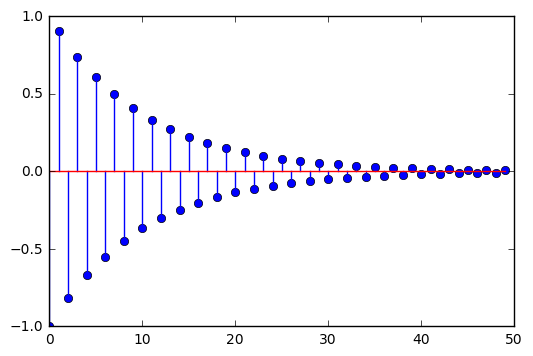

In [10]:
plt.stem(x_truth);

### Numerically check loss and gradient

In [11]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)
model = LinReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.3318851727105898e-06

In [12]:
lbda = 1. / n ** (0.5)
model = LogReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.9652907220844424e-07

### Choice of the model

In [13]:
model = LinReg(A, b, lbda)
#model = LogReg(A, b, lbda)

### Compute the theoretical step-size for FISTA

In [14]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)
#print(model.lipschitz_constant())

step = 0.178631035724


### Get a very precise minimum to compute distances to minimum

In [15]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
print("f", f_min)

f 0.5096757916558352


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BGFS)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [16]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [17]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Ista solver in the cell below

In [18]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x = x - step * grad(x)
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)

    return x

In [19]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err   
       0 | 4.92e-01 | 2.12e+00
      10 | 2.11e-01 | 1.46e+00
      20 | 1.02e-01 | 1.02e+00
      30 | 4.99e-02 | 7.20e-01
      40 | 2.47e-02 | 5.08e-01


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Fista solver in the cell below

In [20]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        x_new = y - step * grad(y)
        t_new = (1 + np.sqrt(1 + 4 * t * t)) / 2.
        y = x_new + ((t - 1) / t) * (x_new - x)
        t = t_new
        x = x_new
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [21]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err   
       0 | 4.92e-01 | 2.12e+00
      10 | 4.58e-02 | 6.91e-01
      20 | 8.83e-03 | 3.00e-01
      30 | 9.48e-04 | 9.84e-02
      40 | 1.83e-03 | 1.39e-01


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [22]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err   
       0 | 4.21e-01 | 1.96e+00
      10 | 3.42e-04 | 4.89e-02
      20 | 2.87e-07 | 8.64e-04
      30 | -3.15e-09 | 1.38e-04
Optimization terminated successfully.
         Current function value: 0.509676
         Iterations: 32
         Function evaluations: 58
         Gradient evaluations: 58


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [23]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err   
       0 | 4.21e-01 | 1.96e+00
      10 | 6.25e-04 | 6.67e-02
      20 | 2.91e-07 | 9.02e-04


### A first numerical comparison of deterministic solvers

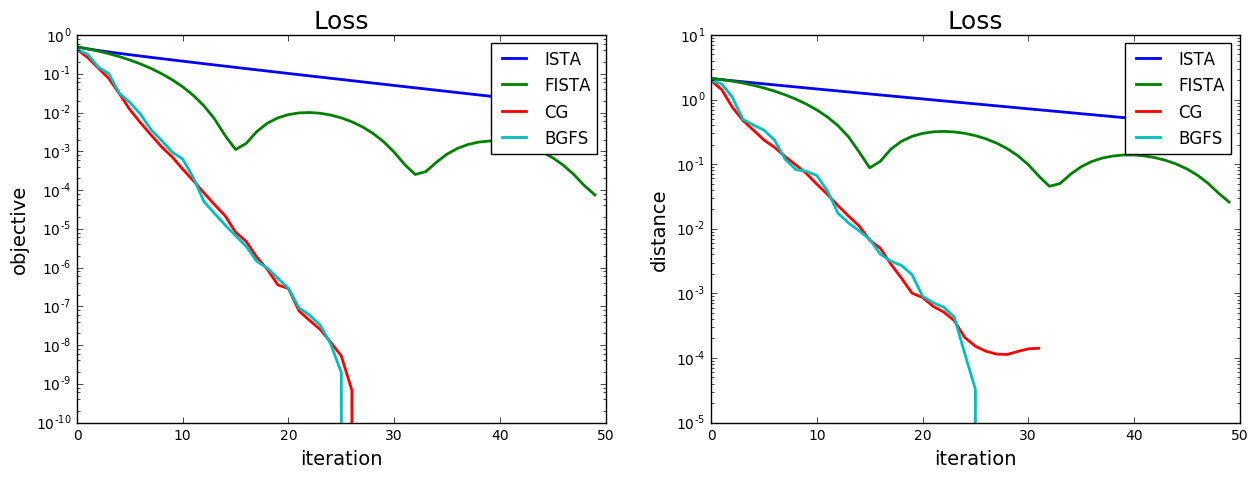

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

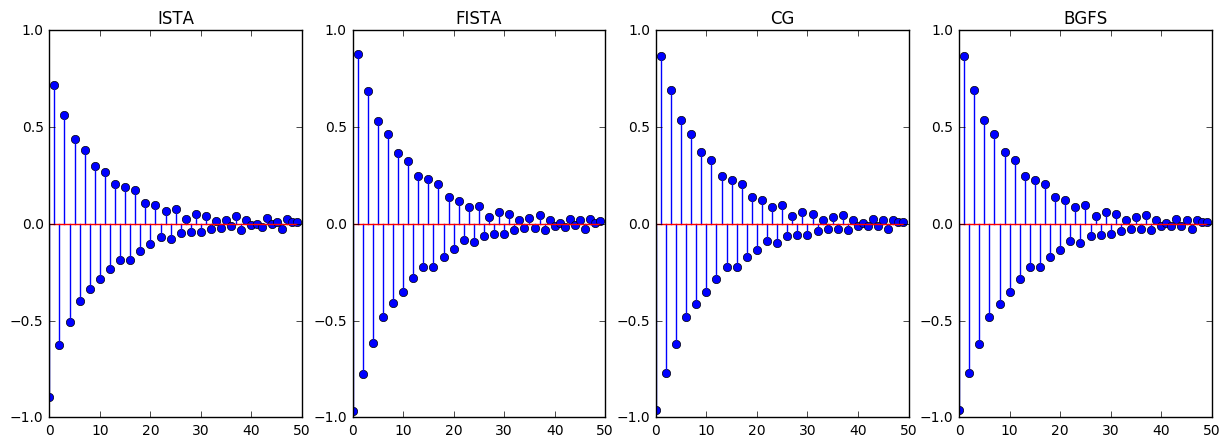

In [25]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

**- Give some first conclusions about the batch solver studied here**

We can see that ISTA has a linear convergence rate, due to the fact that ridge regression loss is strongly convex. FISTA has a linear convergence rate as well, but it converges faster than ISTA. BFGS and CG both converge in less than p iterations (p is the number of features).

**- What do you observe about Fista, is it suprising ?**

We observe that $F(x_k) - F(x^*)$ is bumpy. It is not surprising because FISTA is not a descent algorithm.


<a id='stoc'></a> 
## 4. Stochastic methods

In [26]:
n_iter = 50
# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [27]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step/np.sqrt(idx +1) * grad_i(i, x)
        
        ### END TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x
#print(model.loss(np.zeros(d)))

In [28]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=0.05, callback=sgd_inspector)
print(model.loss(x_sgd))

   it    |   obj    |   err   
       0 | 1.27e+00 | 2.28e+00
      10 | 2.60e-03 | 6.19e-02
      20 | 9.64e-04 | 5.11e-02
      30 | 1.23e-03 | 4.93e-02
      40 | 8.85e-04 | 4.72e-02
0.5105052807755822


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [29]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    for idx in range(n_iter):
        i = iis[idx]
        new_grad = grad_i(i,x) 
        y = (new_grad - gradient_memory[i, :])/n + y
        x = x - step * y
        gradient_memory[i, :] = new_grad
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [30]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)
print(model.loss(x_sag))

   it    |   obj    |   err   
       0 | 5.89e-01 | 2.21e+00
      10 | 9.22e-04 | 4.99e-02
      20 | 1.06e-05 | 3.63e-03
      30 | 1.58e-07 | 5.14e-04
      40 | -2.05e-09 | 1.60e-04
0.5096757880696667


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [31]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    #complete_gradient = grad(x_old)
    
    for idx in range(n_iter):
        i = iis[idx]
        if idx % n == 0:
            x_old = x.copy()
            complete_gradient = grad(x_old)
        x = x - step * (grad_i(i, x) - grad_i(i, x_old) + complete_gradient)
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [32]:
#step = 1. / (20. * model.lipschitz_constant())
# same step as SAG
x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)
print(model.loss(x_svrg))

   it    |   obj    |   err   
       0 | 5.84e-01 | 2.21e+00
      10 | 2.89e-07 | 6.71e-04
      20 | -3.60e-09 | 1.59e-04
      30 | -3.60e-09 | 1.59e-04
      40 | -3.60e-09 | 1.59e-04
0.509675788054954


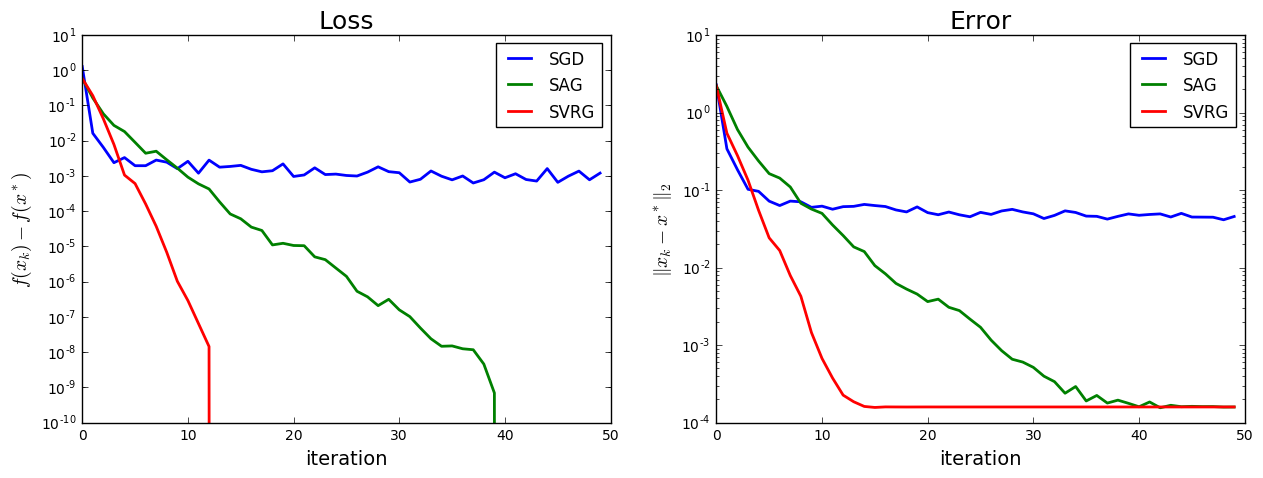

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

- **Compare and comment your results**

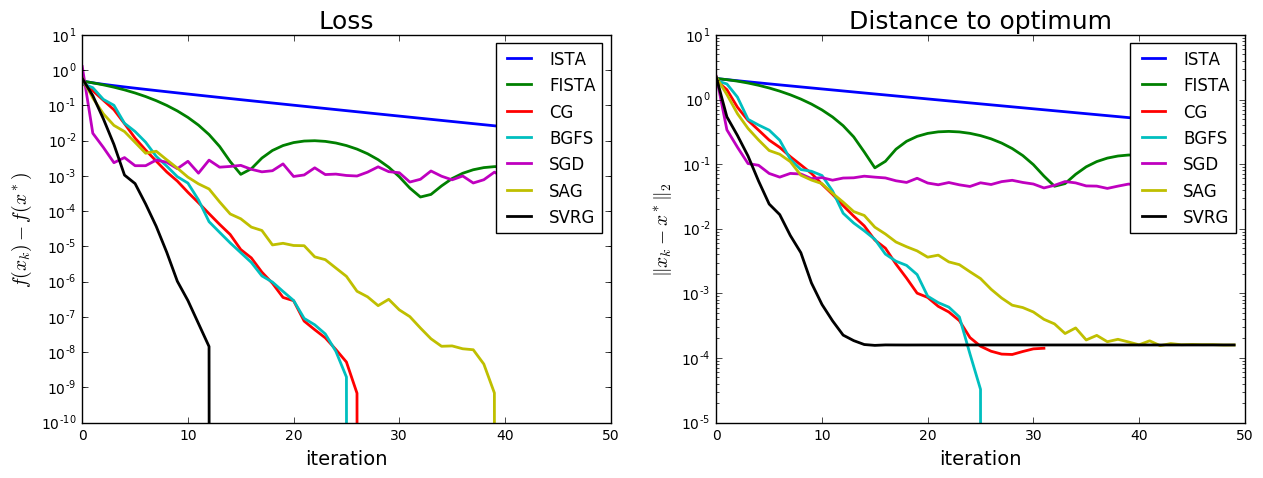

In [34]:
def convergence_plots(inspectors, title=None):
    plt.figure(figsize=(15, 5))
    if title != None:
        plt.suptitle(title, size=14, y=1);
    plt.subplot(1, 2, 1)

    solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

    for insp in inspectors:
        plt.plot(insp.obj, lw=2)
        plt.title("Loss", fontsize=18)
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
        plt.yscale("log")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for insp in inspectors:
        plt.plot(insp.err, lw=2)
        plt.title("Distance to optimum", fontsize=18)
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
        plt.yscale("log")

    plt.legend(solvers);

    
inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
                  sgd_inspector, sag_inspector, svrg_inspector]

convergence_plots(inspectors)

- We can see that SGD objective decays the most in the early iterations, but then the convergence rate becomes very slow. We can also see that variance reduction is effective as it allows the other stochastic methods (SAG and SVRG) to attain linear convergence rates (because of the strong convexity), avoiding the slowdown that hits SGD.
- SVRG, unlike SAG, doesn't need to store gradients for each component, but needs to compute two gradients at each iteration, and also a full gradient periodically.


- ** Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.**

In [35]:
def get_inspectors(model):
    x_init = np.zeros(d)
    
    step = 1. / model.lipschitz_constant()
    
    ista_inspector = inspector(model.loss, x_truth, verbose=False)
    x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

    fista_inspector = inspector(model.loss, x_truth, verbose=False)
    x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

    cg_inspector = inspector(model.loss, x_truth, verbose=False)
    x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

    bfgs_inspector = inspector(model.loss, x_truth, verbose=False)
    x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)
    
    max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))
    
    sgd_inspector = inspector(model.loss, x_truth, verbose=False)
    x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=0.05, callback=sgd_inspector)
    
    if isinstance(model, LogReg):
        step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
    else:
        step = 1.0 / (max_squared_sum + model.lbda / model.n)

    sag_inspector = inspector(model.loss, x_truth, verbose=False)
    x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

    svrg_inspector = inspector(model.loss, x_truth, verbose=False)    
    x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

    inspectors_new = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector, sgd_inspector, sag_inspector, svrg_inspector]
    return inspectors_new

Optimization terminated successfully.
         Current function value: 0.486060
         Iterations: 34
         Function evaluations: 57
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: 0.511165
         Iterations: 35
         Function evaluations: 59
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 0.717948
         Iterations: 22
         Function evaluations: 43
         Gradient evaluations: 43


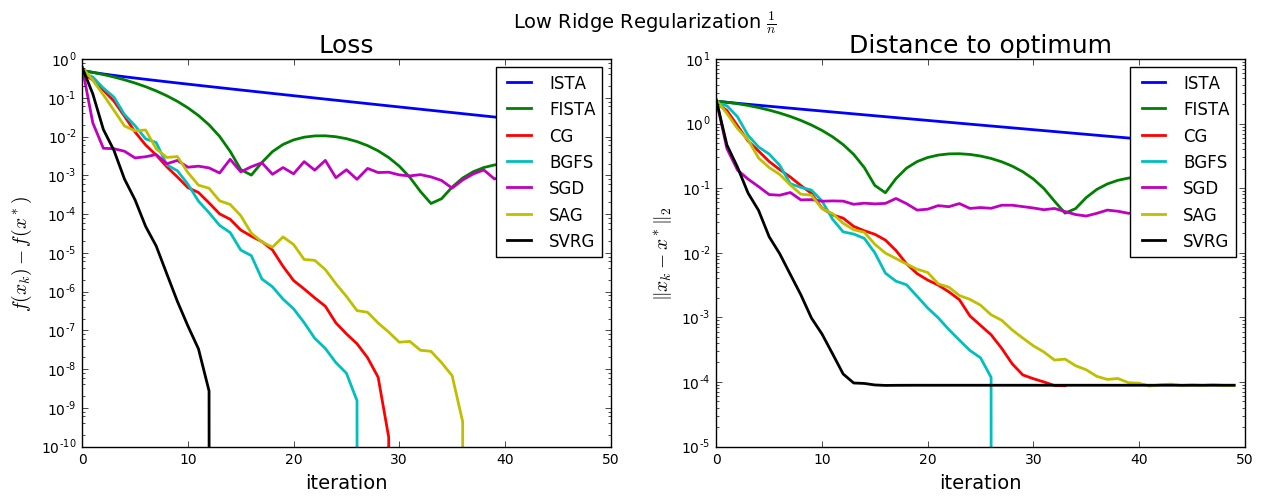

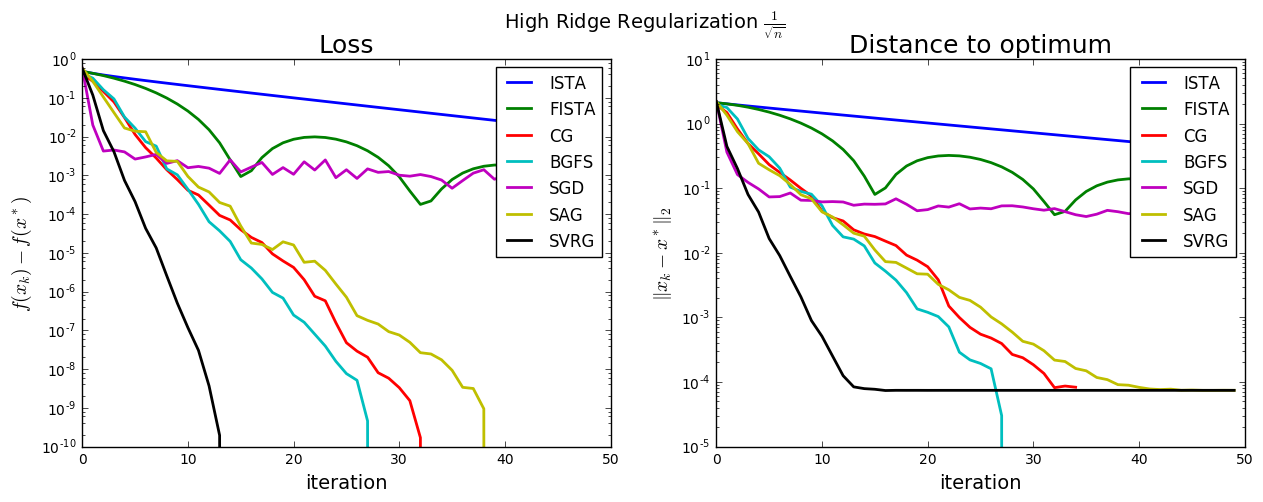

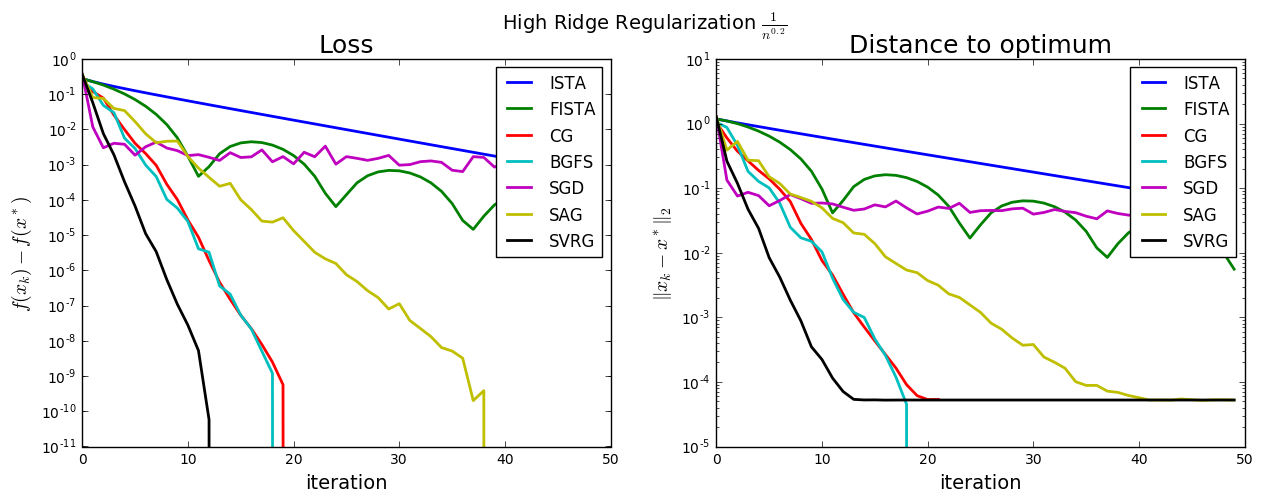

In [40]:
A,b = simu_linreg(x_truth, n, std=1., corr=0.7) 

high_reg = 1. / n ** (0.2)
low_reg = 1./ n

model = LinReg(A, b, lbda=low_reg)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
convergence_plots(get_inspectors(model), title="Low Ridge Regularization "+r"$\frac{1}{n}$")

model = LinReg(A, b, lbda=1/n**(0.5))
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
convergence_plots(get_inspectors(model), title="High Ridge Regularization "+r"$\frac{1}{\sqrt{n}}$")

model = LinReg(A, b, lbda=high_reg)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
convergence_plots(get_inspectors(model), title="High Ridge Regularization "+r"$\frac{1}{n^{0.2}}$")

Going from a low regularization to a high regularization improves the conditioning of the problem, and specifically makes the strong convexity parameter of f larger. Since all algorithms have convergence rates that are decreasing with $\mu$, we observe that all algorithms converge faster with high regularization.

Yet, using a regularization that is too high will focus on the minimisation of the regularization term neglecting the real loss that we want to minimize. It is necessary to find a trade-off between high and low regularizations.

- ** Play also with the level of correlation between features (parameter corr above), and compare results with low and high correlation.**

Optimization terminated successfully.
         Current function value: 0.521135
         Iterations: 19
         Function evaluations: 31
         Gradient evaluations: 31
         Current function value: 0.514430
         Iterations: 50
         Function evaluations: 75
         Gradient evaluations: 75


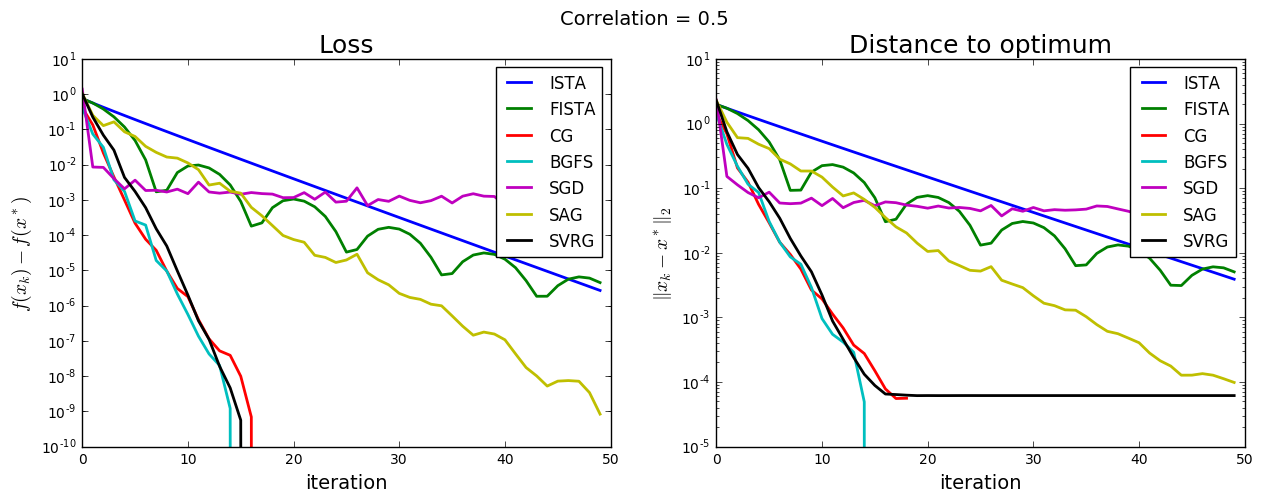

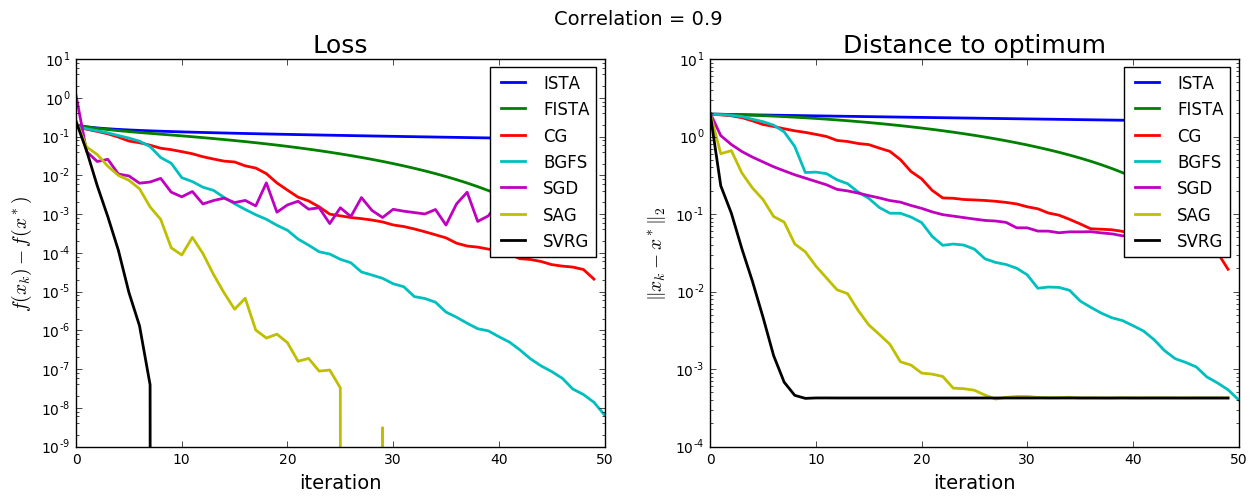

In [39]:
lbda = 1. / n ** (0.5)
high_corr = 0.9
low_corr = 0.5

A,b = simu_linreg(x_truth, n, std=1., corr=low_corr) 
model = LinReg(A, b, lbda=lbda)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
convergence_plots(get_inspectors(model), title="Correlation = " + str(low_corr))

A,b = simu_linreg(x_truth, n, std=1., corr=high_corr) 
model = LinReg(A, b, lbda=lbda)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
convergence_plots(get_inspectors(model), title="Correlation = " + str(high_corr))

Again, FISTA is significantly better than ISTA for high correlation, but both methods see their convergence rate decline with higher correlation, which is consistent with the fact that their numerical complexity is proportional to the $L$ Lipschitz constant of the gradient of f, which grows with the amount of correlation.

BFGS and Conjugate gradient have significantly slower convergence rates with high correlation, whih suggests that their numerical complexities are also determined by the condition number of A (the higher the correlation, the larger the condition number and the slower the convergence speed).

Stochastic methods are more robust to the correlation of the features. Under high correlation, SGD has slightly slower convergence rate, while SVRG and SAG actually have improved convergence rates. Indeed, the numerical complexity of both SVRG and SAG depends on the smoothness parameter of the individual functions $f_i$ : $L_{max} = max_{i=1 \dots i=n} L_i$ and not $L$ the smoothness constant of the separable function $f$, which is usually larger.

**- Conclude**

- If we can only afford one pass through the data, then SGD should be used.
- If we can afford to do many passes through the data (a few hundred), then BFGS or CG should be used because they achieve a more precise solution.
- If we are between these two cases, then we should use SVRG. Indeed, it starts out better than all deterministic methods, with a performance similar to SGD, but the SAG iterations continue to make steady progress even after the first few passes through the data. This leads to better performance than SGD on later iterations.
- It is also possible to do a combination of these algorithms especially using SGD for the first iterations and then one of the others according to the conditioning and parameters of the problem.